Dataset Head:
   Unnamed: 0      Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTGS  ATGS  \
0           0  19/08/00  Charlton       Man City     4     0   H     0     0   
1           1  19/08/00   Chelsea       West Ham     4     2   H     0     0   
2           2  19/08/00  Coventry  Middlesbrough     1     3  NH     0     0   
3           3  19/08/00     Derby    Southampton     2     2  NH     0     0   
4           4  19/08/00     Leeds        Everton     2     0   H     0     0   

   HTGC  ...  HTLossStreak3  HTLossStreak5  ATWinStreak3 ATWinStreak5  \
0     0  ...              0              0             0            0   
1     0  ...              0              0             0            0   
2     0  ...              0              0             0            0   
3     0  ...              0              0             0            0   
4     0  ...              0              0             0            0   

  ATLossStreak3 ATLossStreak5 HTGD ATGD DiffPts DiffFormPts  
0   

/tmp/ipykernel_39089/1503301566.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
/tmp/ipykernel_39089/1503301566.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_teams, x='Team', y='TotalMatches', palette='viridis')


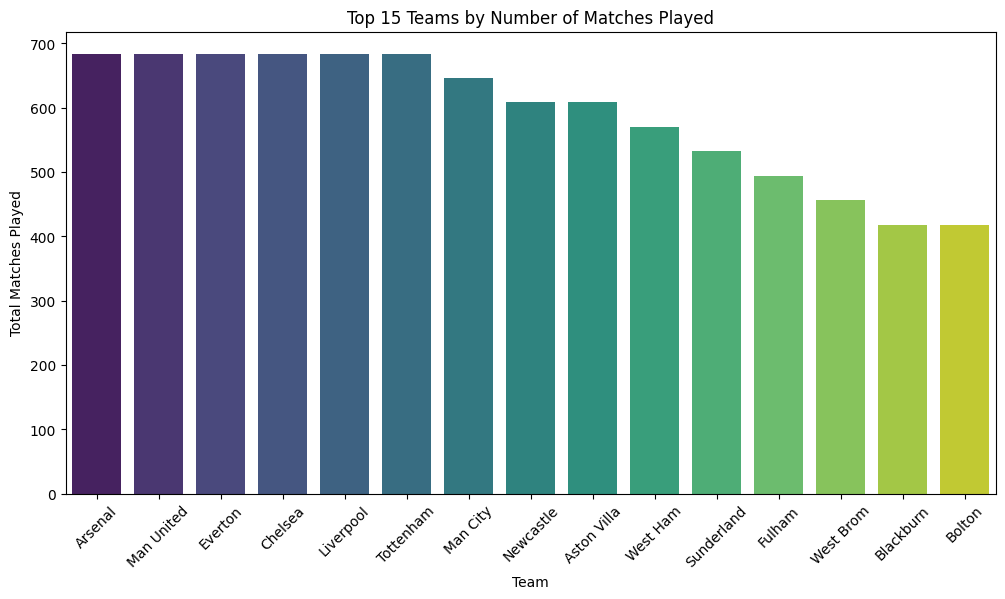

/tmp/ipykernel_39089/1503301566.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ratings_df, x='Team', y='EloRating', palette='coolwarm')


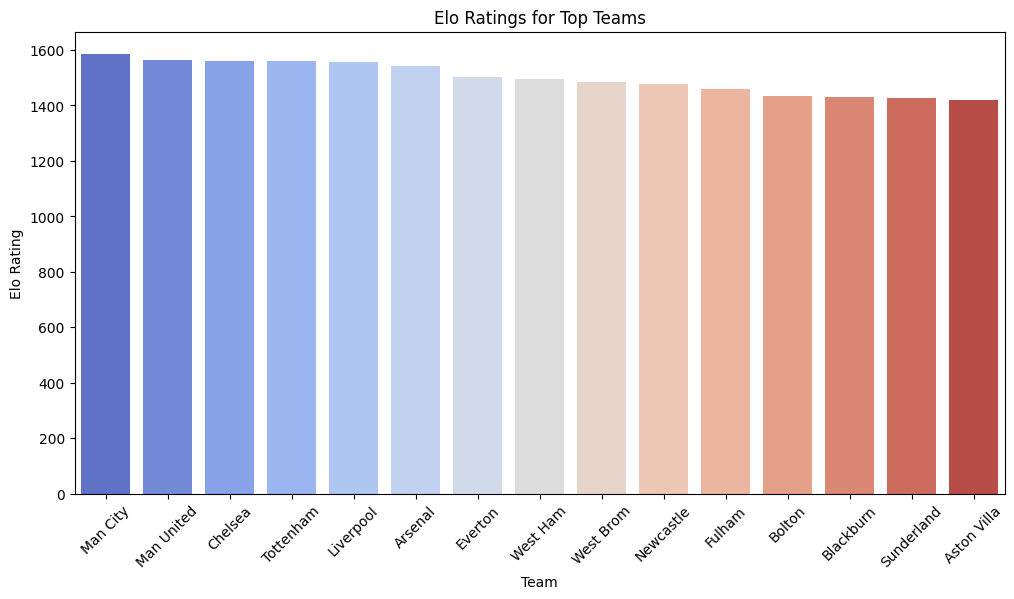

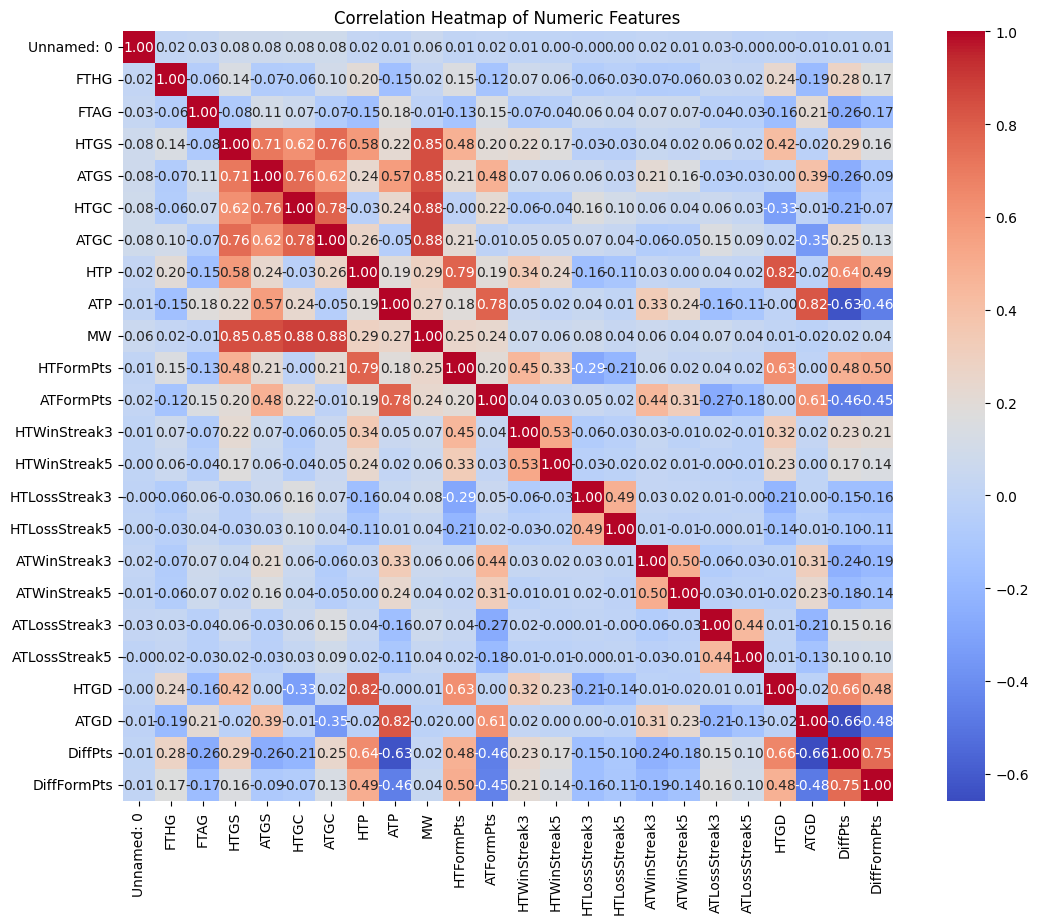

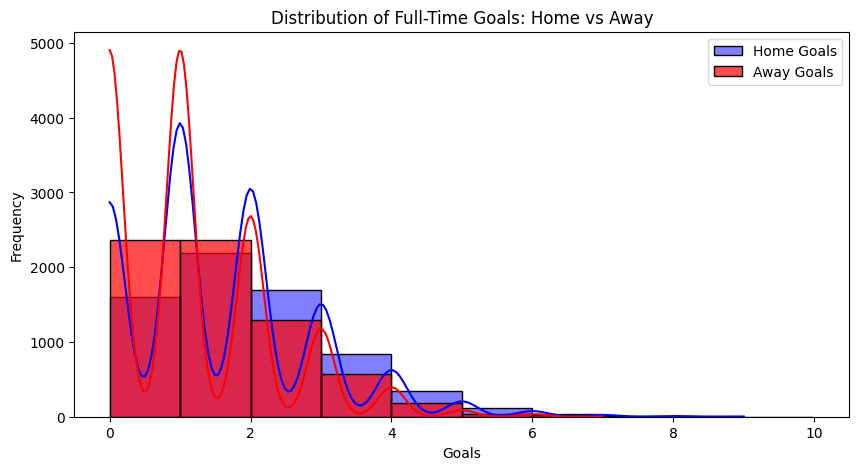

/tmp/ipykernel_39089/1503301566.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ftr_counts.index, y=ftr_counts.values, palette="viridis")


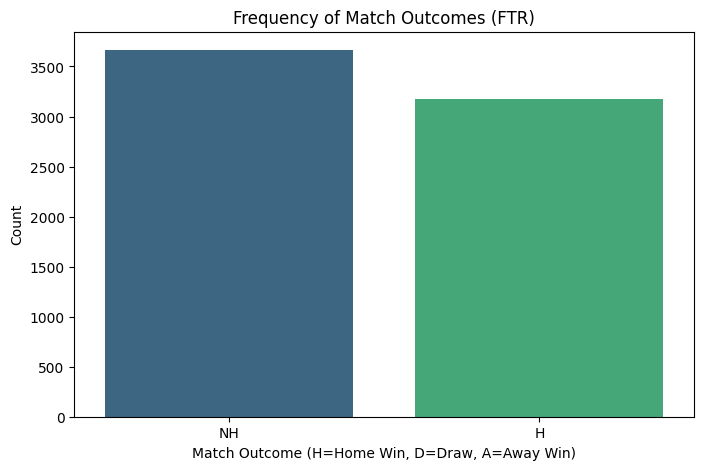

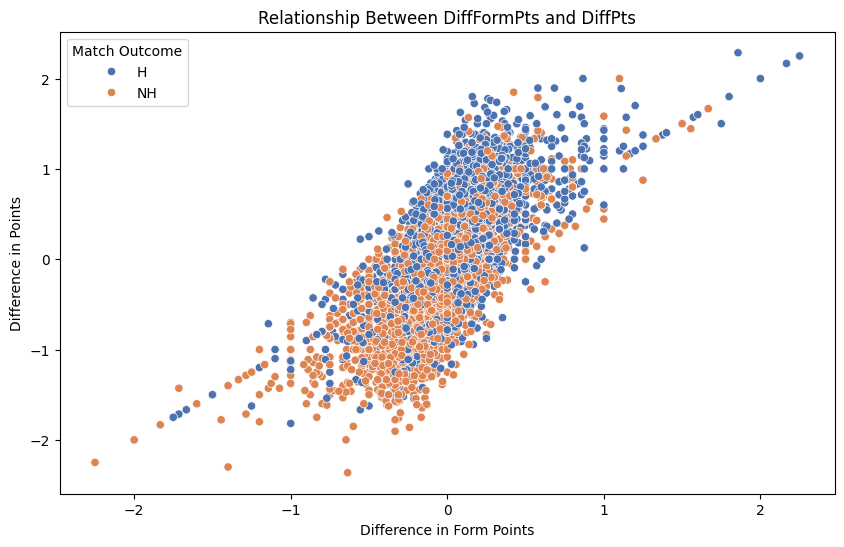

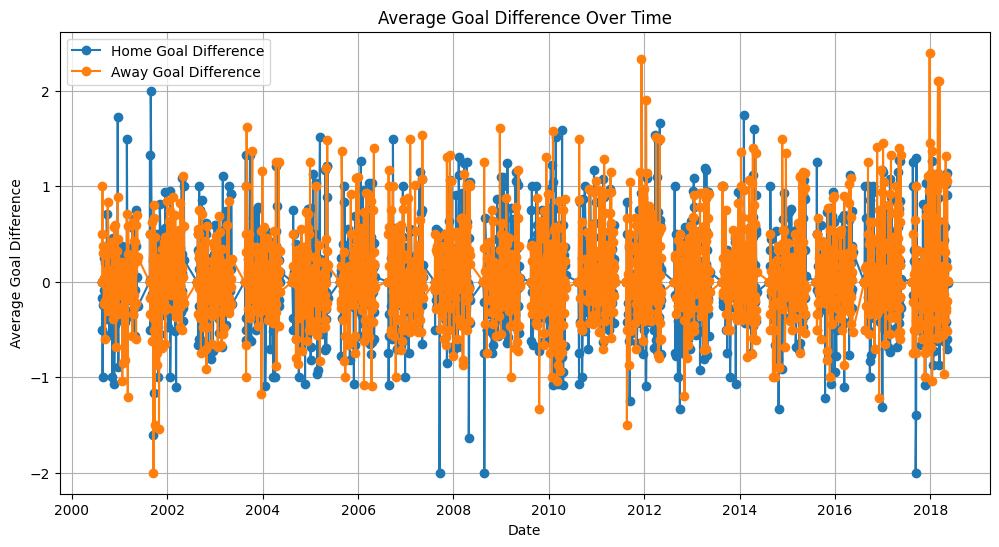

/media/toni-birat/New Volume/English_Premier_League_Complete_Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
23:13:38 - cmdstanpy - INFO - Chain [1] start processing
23:13:38 - cmdstanpy - INFO - Chain [1] done processing


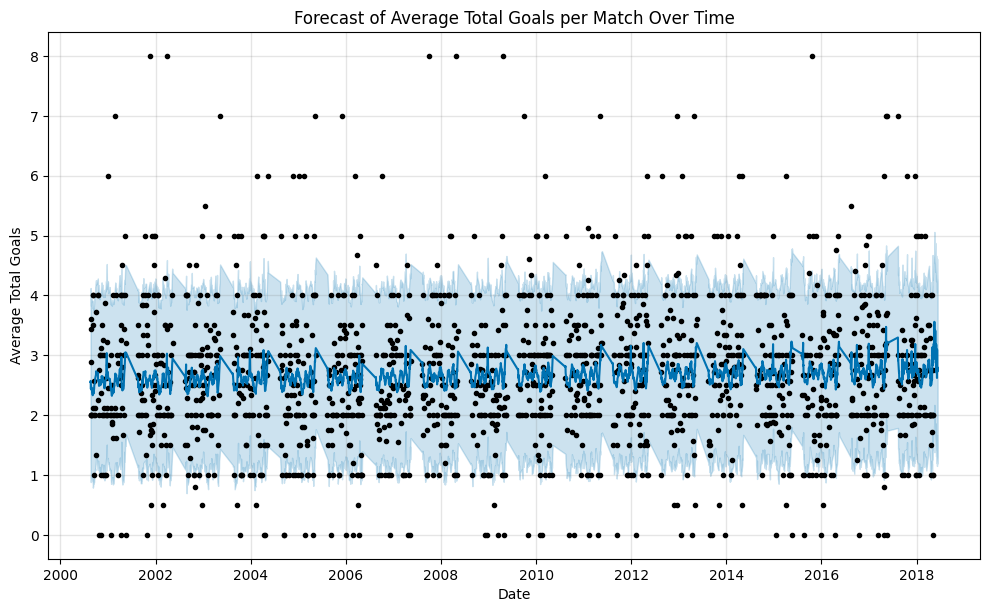

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.56       634
           1       0.62      0.66      0.64       734

    accuracy                           0.60      1368
   macro avg       0.60      0.60      0.60      1368
weighted avg       0.60      0.60      0.60      1368

Confusion Matrix:
[[339 295]
 [246 488]]
Gradient Boosting Classifier Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       634
           1       0.64      0.73      0.68       734

    accuracy                           0.63      1368
   macro avg       0.63      0.63      0.63      1368
weighted avg       0.63      0.63      0.63      1368

Confusion Matrix:
[[330 304]
 [196 538]]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# ---------------------------
# 1. Load and Understand the Dataset
# ---------------------------

# Load the dataset (ensure 'final_dataset.csv' is in your working directory)
df = pd.read_csv("../Datasets/final_dataset.csv")

# Display basic info to understand structure
print("Dataset Head:")
print(df.head())
print("\nColumns:")
print(df.columns.tolist())
print("\nStatistical Summary:")
print(df.describe())

# Convert 'Date' column to datetime (adjust dayfirst if necessary)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# ---------------------------
# 2. Exploratory Data Analysis (EDA) and Visualizations
# ---------------------------

home_counts = df.groupby('HomeTeam').size().reset_index(name='home_matches')
away_counts = df.groupby('AwayTeam').size().reset_index(name='away_matches')

# Merge counts for each team
team_matches = pd.merge(home_counts, away_counts, left_on='HomeTeam', right_on='AwayTeam', how='outer').fillna(0)
team_matches['Team'] = team_matches['HomeTeam'].combine_first(team_matches['AwayTeam'])
team_matches['TotalMatches'] = team_matches['home_matches'] + team_matches['away_matches']

# Select only the Team and TotalMatches columns and sort
team_matches = team_matches[['Team', 'TotalMatches']].sort_values('TotalMatches', ascending=False)

# Plot the top 15 teams by matches played
top_teams = team_matches.head(15)
plt.figure(figsize=(12,6))
sns.barplot(data=top_teams, x='Team', y='TotalMatches', palette='viridis')
plt.title("Top 15 Teams by Number of Matches Played")
plt.xlabel("Team")
plt.ylabel("Total Matches Played")
plt.xticks(rotation=45)
plt.show()

# ---------------------------
# 2. Implement an Elo Rating System for the Top Teams
# ---------------------------

# Extract the team names from the top teams viz
teams = top_teams['Team'].unique()

# Initialize Elo ratings (starting at 1500 for each team)
elo_ratings = {team: 1500 for team in teams}

# Define a K-factor
K = 20

# Function to calculate the expected score for team A vs. team B
def expected_score(rating_a, rating_b):
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

# Filter the dataset for matches where both teams are in our top teams list
df_top = df[(df['HomeTeam'].isin(teams)) & (df['AwayTeam'].isin(teams))].copy()
df_top = df_top.sort_values('Date')

# Loop through each match to update Elo ratings
for idx, row in df_top.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Determine match outcome based on FTR:
    # Assume 'H' = home win, 'A' = away win, and 'D' = draw.
    if row['FTR'] == 'H':
        s_home, s_away = 1, 0
    elif row['FTR'] == 'A':
        s_home, s_away = 0, 1
    else:  # Draw or other outcomes assumed as draw
        s_home, s_away = 0.5, 0.5

    # Calculate expected scores
    e_home = expected_score(elo_ratings[home_team], elo_ratings[away_team])
    e_away = expected_score(elo_ratings[away_team], elo_ratings[home_team])

    # Update ratings
    elo_ratings[home_team] += K * (s_home - e_home)
    elo_ratings[away_team] += K * (s_away - e_away)

# Convert Elo ratings to a DataFrame and sort by rating descending
ratings_df = pd.DataFrame(list(elo_ratings.items()), columns=['Team', 'EloRating']).sort_values('EloRating', ascending=False)

# Plot Elo ratings for the top teams
plt.figure(figsize=(12,6))
sns.barplot(data=ratings_df, x='Team', y='EloRating', palette='coolwarm')
plt.title("Elo Ratings for Top Teams")
plt.xlabel("Team")
plt.ylabel("Elo Rating")
plt.xticks(rotation=45)
plt.show()

# Visualization 1: Correlation Heatmap of Numeric Columns
plt.figure(figsize=(14, 10))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Visualization 2: Distribution of Full-Time Goals for Home vs Away
plt.figure(figsize=(10, 5))
sns.histplot(df['FTHG'], color="blue", label="Home Goals", kde=True, bins=range(int(df['FTHG'].min()), int(df['FTHG'].max())+2))
sns.histplot(df['FTAG'], color="red", label="Away Goals", kde=True, bins=range(int(df['FTAG'].min()), int(df['FTAG'].max())+2), alpha=0.7)
plt.title("Distribution of Full-Time Goals: Home vs Away")
plt.xlabel("Goals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualization 3: Frequency of Match Outcomes (FTR)
plt.figure(figsize=(8, 5))
ftr_counts = df['FTR'].value_counts()
sns.barplot(x=ftr_counts.index, y=ftr_counts.values, palette="viridis")
plt.title("Frequency of Match Outcomes (FTR)")
plt.xlabel("Match Outcome (H=Home Win, D=Draw, A=Away Win)")
plt.ylabel("Count")
plt.show()

# Visualization 4: Relationship Between Difference in Form Points and Difference in Points
# 'DiffFormPts' vs 'DiffPts' might indicate how recent performance translates to point differences.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='DiffFormPts', y='DiffPts', hue='FTR', palette="deep")
plt.title("Relationship Between DiffFormPts and DiffPts")
plt.xlabel("Difference in Form Points")
plt.ylabel("Difference in Points")
plt.legend(title="Match Outcome")
plt.show()

# Visualization 5: Average Goal Difference (HTGD vs ATGD) by Date
# This can show how the overall goal performance for home and away teams evolves over time.
avg_goal_diff = df.groupby('Date')[['HTGD', 'ATGD']].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(avg_goal_diff['Date'], avg_goal_diff['HTGD'], label="Home Goal Difference", marker='o')
plt.plot(avg_goal_diff['Date'], avg_goal_diff['ATGD'], label="Away Goal Difference", marker='o')
plt.title("Average Goal Difference Over Time")
plt.xlabel("Date")
plt.ylabel("Average Goal Difference")
plt.legend()
plt.grid(True)
plt.show()

from prophet import Prophet

df['TotalGoals'] = df['FTHG'] + df['FTAG']

# Aggregate data: Compute the average Total Goals per match for each date
df_total = df.groupby('Date')['TotalGoals'].mean().reset_index()

# Rename columns for Prophet: 'ds' for datestamp and 'y' for the target variable (TotalGoals)
df_total.rename(columns={'Date': 'ds', 'TotalGoals': 'y'}, inplace=True)

# Initialize and fit the Prophet model
model_total = Prophet()
model_total.fit(df_total)

# Create a dataframe to hold predictions for the next 30 days
future_total = model_total.make_future_dataframe(periods=30)
forecast_total = model_total.predict(future_total)

# Plot the forecast for average Total Goals per match
fig_total = model_total.plot(forecast_total)
plt.title("Forecast of Average Total Goals per Match Over Time")
plt.xlabel("Date")
plt.ylabel("Average Total Goals")
plt.show()

features = [
    'HTFormPts',    # Home team recent form points
    'ATFormPts',    # Away team recent form points
    'DiffFormPts',  # Difference in form points between teams
    'DiffPts',      # Difference in overall points
    'HTWinStreak3', # Home team's win streak in last 3 games
    'ATWinStreak3', # Away team's win streak in last 3 games
    'HTLossStreak3',# Home team's loss streak in last 3 games
    'ATLossStreak3',# Away team's loss streak in last 3 games
    'HTGD',         # Home team goal difference
    'ATGD'          # Away team goal difference
]
target = 'FTR'  # Match outcome (e.g., H, D, A)

# Drop rows with missing values in the selected columns
data = df.dropna(subset=features + [target]).copy()

# Encode the target labels to numeric values if they're not already numeric.
# For example, if FTR is represented as 'H', 'D', 'A', this will encode them to 0, 1, 2.
le = LabelEncoder()
data[target] = le.fit_transform(data[target])

# Prepare the features matrix (X) and target vector (y)
X = data[features]
y = data[target]

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict outcomes on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# Predict outcomes on the test set
y_pred = gb_clf.predict(X_test)

# Evaluate the model's performance
print("Gradient Boosting Classifier Performance:")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Analysis of Football Match Dataset Visualizations

This comprehensive analysis examines multiple visualizations from the football match dataset to understand patterns, relationships, and insights that can inform machine learning model selection and feature engineering.

## 1. Top 15 Teams by Number of Matches Played

**Key Insights:**
- Arsenal, Manchester United, Everton, Chelsea, Liverpool, and Tottenham lead with 684 matches each, indicating these are established Premier League teams with consistent participation
- Manchester City follows closely with 646 matches, showing recent Premier League prominence
- Newcastle and Aston Villa have 608 matches each, representing teams with occasional relegation/promotion
- The distribution shows clear tiers of team participation, which correlates with league stability

**Model Impact:** This visualization helps identify which teams have sufficient historical data for reliable predictions. Teams with fewer matches may require different modeling approaches or feature engineering.

## 2. Elo Ratings for Top Teams

**Key Insights:**
- Manchester City tops the Elo ratings (~1587), reflecting their recent dominance
- Manchester United (~1565) and Chelsea (~1561) follow, showing historical strength
- Tottenham and Liverpool cluster around 1558-1557, indicating similar competitive levels
- Arsenal sits at ~1544, despite high match count, suggesting recent decline in performance
- Bottom-tier teams (Aston Villa ~1418, Sunderland ~1427) show clear separation from top teams

**Model Impact:** Elo ratings provide a dynamic strength measure that captures recent form better than static statistics. This feature could significantly improve match outcome predictions.

## 3. Correlation Heatmap of Numeric Features

**Key Insights:**
- Strong positive correlations exist between:
  - HTP (Home Team Points) and HTFormPts (0.79) - validates consistency in team strength metrics
  - ATP (Away Team Points) and ATFormPts (0.78) - similar validation for away teams
  - DiffPts and DiffFormPts (0.75) - shows form differences align with overall point differences
- Goal statistics show expected correlations:
  - HTGD and HTP (0.82) - teams with better goal difference tend to have more points
  - ATGD and ATP (0.82) - similar relationship for away teams
- Moderate correlations between goals scored and team strength metrics

**Model Impact:** High correlations suggest potential multicollinearity issues. Feature selection or regularization techniques may be needed to avoid overfitting.

## 4. Distribution of Full-Time Goals: Home vs Away

**Key Insights:**
- Home teams show a slight advantage in goal scoring distribution
- Both distributions are right-skewed with most matches having 0-3 goals per team
- Peak frequency occurs at 1 goal for both home and away teams
- Home teams have a marginally higher probability of scoring 2+ goals
- Very few matches see teams scoring 5+ goals

**Model Impact:** The similar distributions suggest goal-based features should be treated equally for home/away teams. The right-skewed nature indicates potential benefits from log transformation or binning strategies.

## 5. Frequency of Match Outcomes (FTR)

**Key Insights:**
- Away wins or draws (NH) dominate with 3,664 occurrences
- Home wins (H) account for 3,176 matches
- This shows a relatively balanced dataset with slight favor toward non-home victories
- The balance is important for classification model performance

**Model Impact:** The relatively balanced target distribution suggests standard classification algorithms should perform well without significant class balancing techniques.

## 6. Relationship Between DiffFormPts and DiffPts

**Key Insights:**
- Strong positive correlation visible in the scatter plot
- Home wins (H) tend to cluster in the upper-right quadrant (positive differences)
- Away/Draw outcomes (NH) concentrate in the lower-left quadrant (negative differences)
- Clear linear relationship suggests form points are predictive of match outcomes
- Some outliers exist where form doesn't match overall point differences

**Model Impact:** This relationship validates using both DiffFormPts and DiffPts as features, though their correlation suggests potential redundancy. The clear separation by outcome indicates these are strong predictive features.

## 7. Average Goal Difference Over Time

**Key Insights:**
- Both home and away goal differences fluctuate around zero over time
- Seasonal patterns are visible with periodic oscillations
- Home goal difference shows slightly more positive values, confirming home advantage
- No clear long-term trends, suggesting the dataset spans relatively stable competitive periods
- Volatility appears consistent across the timeline

**Model Impact:** The time-series nature suggests temporal features (season, match week) could be valuable. The stability indicates the dataset is suitable for machine learning without major trend adjustments.

## 8. Prophet Forecast of Average Total Goals

**Key Insights:**
- The forecast shows seasonal patterns in goal scoring
- Average total goals per match fluctuate between approximately 1.5-4.0
- Clear cyclical patterns suggest seasonal effects (likely corresponding to football seasons)
- The trend appears relatively stable with periodic variations
- Future predictions maintain similar patterns to historical data

**Model Impact:** This validates including temporal features and suggests ensemble methods combining time-series forecasting with traditional ML could be beneficial.

## Overall Dataset Assessment for Model Selection

**Strengths:**
1. Balanced target variable suitable for standard classification
2. Rich feature set with both static and dynamic team metrics
3. Sufficient historical data for most teams
4. Clear predictive relationships between features and outcomes

**Challenges:**
1. High correlations between some features requiring feature selection
2. Varying data availability across teams
3. Time-dependent patterns requiring careful train/test splitting

**Recommended Modeling Approach:**
- Use ensemble methods (Random Forest, Gradient Boosting) as implemented
- Include Elo ratings as dynamic strength measures
- Apply feature selection to handle multicollinearity
- Consider temporal validation to account for time-series nature
- Explore team-specific models for teams with extensive data

The visualizations collectively demonstrate a well-structured dataset with clear predictive signals, justifying the machine learning approach taken in the analysis.